# Decarbonising Housing

In [1]:
from sqlalchemy import create_engine
import pandas as pd
import geopandas as gpd
import psycopg2
from psycopg2 import sql
import plotly.express as px
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import folium
import os

# move current directory to /Users/tanyatsui/Documents/01_Projects/housingEmissions
os.chdir('/Users/tanyatsui/Documents/01_Projects/housingEmissions')

In [2]:
# create a connection to the database
db_name = 'urbanmining'
db_user = 'postgres'
db_password = 'Tunacompany5694!'
db_host = 'localhost'
db_port = '5432'
engine = create_engine(f'postgresql://{db_user}:{db_password}@{db_host}:{db_port}/{db_name}')


# Housing emissions for the Netherlands (2012-2021)

### Yearly emissions - total, embodied, operational

In [10]:
query = ''' 
SELECT year, SUM(embodied_kg) AS embodied_kg, SUM(operational_kg) AS operational_kg, SUM(embodied_kg + operational_kg) AS total_kg
FROM emissions_all_wijk
GROUP BY year
'''
df = pd.read_sql_query(query, engine)

# px bar chart of embodied and operational emissions
fig = px.bar(df, x='year', y=['operational_kg', 'embodied_kg'], title='Housing emissions for the Netherlands (2012-2021)', 
             labels={'value':'kg CO2e', 'variable':'Emission Type', 'year':'Year'})
fig.update_layout(width=800)
fig.show()

In [11]:
query = ''' 
SELECT SUM(embodied_kg) AS embodied_kg, SUM(operational_kg) AS operational_kg, SUM(embodied_kg + operational_kg) AS total_kg
FROM emissions_all_wijk
'''

df = pd.read_sql_query(query, engine)

df_long = pd.melt(df, var_name='kg_type', value_name='kg')
df_long = df_long[df_long.kg_type != 'total_kg']

# plotly pie chart 
fig = px.pie(df_long, values='kg', names='kg_type', title='Total CO2 emissions by type')
fig.update_layout(width=500)
fig.show()

### Comparing different municipalities on a matrix

In [48]:
query = ''' 
WITH stats_with_municipality AS (
	SELECT b.municipality, a.wk_code, a.wk_geom, ST_Area(wk_geom)/1000000 AS wk_area, 
		a.year, a.n_units AS n_homes, 
		a.construction, a.transformation, a.renovation, a.demolition, 
		a.inuse, a.population, a.av_woz, 
		a.embodied_kg_s0 AS embodied_kg, a.operational_kg_s0 AS operational_kg
	FROM emissions_all_wijk_s1 a 
	LEFT JOIN key_wijk2012_to_municipality2022 b 
	ON a.wk_code = b.wk_code
), 
stats_municipality_per_year AS (
	SELECT municipality, year, 
		SUM(n_homes) AS n_homes, 
        SUM(inuse) / SUM(n_homes) AS av_home_sqm, 
	
        SUM(construction) / SUM(inuse) * 100 AS p_construction, 
        SUM(transformation) / SUM(inuse) * 100 AS p_transformation,
        SUM(renovation) / SUM(inuse) * 100 AS p_renovation,
        SUM(demolition) / SUM(inuse) * 100 AS p_demolition,
	
		SUM(population) AS population, ROUND(AVG(av_woz)) AS av_woz, 
		SUM(population) / SUM(wk_area) AS population_density, 
		SUM(population) / SUM(n_homes) AS people_per_home, 
	
		ROUND(SUM(embodied_kg) / SUM(n_homes)) AS embodied_kg_perhome, 
		ROUND(SUM(operational_kg) / SUM(n_homes)) AS operational_kg_perhome
	FROM stats_with_municipality
	GROUP BY municipality, year
), 
stats_municipality AS (
	SELECT municipality, ROUND(AVG(av_home_sqm)) AS av_home_sqm, 
	
		AVG(p_construction) AS p_construction, AVG(p_transformation) AS p_transformation,
        AVG(p_renovation) AS p_renovation, AVG(p_demolition) AS p_demolition,
	
		ROUND(AVG(population)) AS population, ROUND(AVG(av_woz)) AS av_woz,
		ROUND(AVG(population_density)) AS population_density, 
		ROUND(AVG(people_per_home)) AS people_per_home, 
	
		ROUND(AVG(embodied_kg_perhome)) AS embodied_kg_perhome,
		ROUND(AVG(operational_kg_perhome)) AS operational_kg_perhome
    FROM stats_municipality_per_year
    GROUP BY municipality
), 
municipalities AS (
	SELECT * FROM nl_gemeenten WHERE "H2O" = 'NEE'
)
	
SELECT a.*, b.geometry
FROM stats_municipality a 
LEFT JOIN municipalities b 
ON a.municipality = b."GM_NAAM"
'''
gdf = gpd.read_postgis(query, engine, geom_col='geometry')

In [49]:
av_operational = gdf.operational_kg_perhome.mean()
av_embodied = gdf.embodied_kg_perhome.mean()

def classify_municipality(row): 
    operational_col = 'operational_kg_perhome'
    embodied_col = 'embodied_kg_perhome'
    if row[operational_col] > av_operational and row[embodied_col] > av_embodied: 
        return 'inefficient'
    elif row[operational_col] > av_operational and row[embodied_col] < av_embodied:
        return 'energy heavy'
    elif row[operational_col] < av_operational and row[embodied_col] > av_embodied:
        return 'material heavy'
    else:
        return 'efficient'
gdf['municipality_type'] = gdf.apply(lambda row: classify_municipality(row), axis=1)

color_dict = {
    'inefficient': '#636EFA', 
    'efficient': '#EF553B',
    'material heavy': '#AB63FA', 
    'energy heavy': '#00CC96'
}
fig = px.scatter(gdf, x='operational_kg_perhome', y='embodied_kg_perhome', 
                 # log_x=True, log_y=True, 
                 hover_name='municipality', color='municipality_type', color_discrete_map=color_dict, 
                 title="Operational vs embodied emissions (per home) of municipalities") 
fig.update_layout(width=800, height=700)
fig.show()


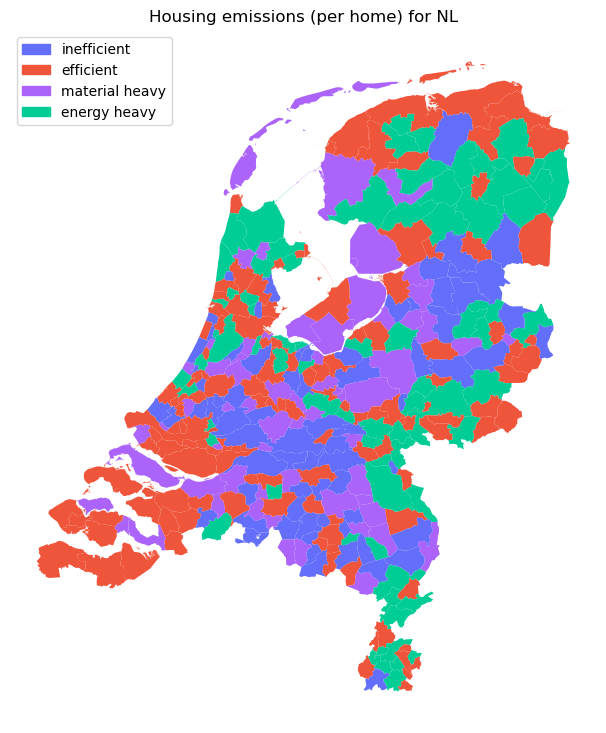

In [50]:
import matplotlib.patches as mpatches
df = gdf.copy()
color_dict = {
    'inefficient': '#636EFA', 
    'efficient': '#EF553B',
    'material heavy': '#AB63FA', 
    'energy heavy': '#00CC96'
}
df['color'] = df['municipality_type'].map(color_dict)
fig, ax = plt.subplots(figsize=(15, 9))
df.plot(color=df['color'], legend=True, ax=ax, legend_kwds={'loc': 'center left', 'bbox_to_anchor': (1.8, 1)})
ax.set_axis_off()
legend_patches = [mpatches.Patch(color=color, label=label) for label, color in color_dict.items()]
ax.legend(handles=legend_patches, loc='upper left')
ax.set_title('Housing emissions (per home) for NL')
plt.show()

In [58]:
fig = px.box(gdf, x='municipality_type', y='av_woz', color='municipality_type', title='Average per sqm value (euros) per municipality type')
fig.update_layout(width=800)
fig.show()

fig = px.box(gdf, x='municipality_type', y='population_density', color='municipality_type', title='Population density per municipality type')
fig.update_layout(width=800)
fig.show()

fig = px.box(gdf, x='municipality_type', y='av_home_sqm', color='municipality_type', title='Av. home size per municipality type')
fig.update_layout(width=800)
fig.show()

fig = px.box(gdf, x='municipality_type', y='people_per_home', color='municipality_type', title='Av. people per home per municipality type')
fig.update_layout(width=800)
fig.show()

In [46]:
gdf_long = pd.melt(gdf, id_vars=['municipality', 'municipality_type'], value_vars=['p_construction', 'p_transformation', 'p_renovation', 'p_demolition'], 
                   var_name='activity_type', value_name='percent')
fig = px.box(gdf_long, x='activity_type', y='percent', color='municipality_type', title='Percentage of construction activity per municipality type')
fig.update_layout(width=800)
fig.show()

# Scenario 1 - energy efficiency

### Comparing scenario 1 with original - total, embodied, operational

In [3]:
query = f''' 
WITH emissions_year AS (
    SELECT year,  
        SUM(operational_kg_s0) AS operational_kg_s0, 
        SUM(operational_kg_s1) AS operational_kg_s1, 
        SUM(operational_kg_s1) - SUM(operational_kg_s0) AS diff_operational,
        SUM(embodied_kg_s0) AS embodied_kg_s0, 
        SUM(embodied_kg_s1) AS embodied_kg_s1, 
        SUM(embodied_kg_s1) - SUM(embodied_kg_s0) AS diff_embodied,
        SUM(operational_kg_s0 + embodied_kg_s0) AS total_kg_s0,
        SUM(operational_kg_s1 + embodied_kg_s1) AS total_kg_s1, 
        SUM(operational_kg_s1 + embodied_kg_s1) - SUM(operational_kg_s0 + embodied_kg_s0) AS diff_total
    FROM emissions_all_wijk_s1
    GROUP BY year
)
SELECT * FROM emissions_year ORDER BY year
'''

df = pd.read_sql_query(query, engine)

fig = px.bar(df, x='year', y=['total_kg_s0', 'total_kg_s1'], 
             title=f'Housing emissions for the Netherlands (2012-2021)',
                labels={'value':'kg CO2e', 'variable':'Emission Type', 'year':'Year'}, barmode='group')
fig.update_layout(width=800)
fig.show()

fig = px.bar(df, x='year', y=['embodied_kg_s0', 'embodied_kg_s1'], 
             title=f'Embodied emissions for the Netherlands (2012-2021)',
                labels={'value':'kg CO2e', 'variable':'Emission Type', 'year':'Year'}, barmode='group')
fig.update_layout(width=800)
fig.show()

fig = px.bar(df, x='year', y=['operational_kg_s0', 'operational_kg_s1'], 
             title=f'Operational emissions for the Netherlands (2012-2021)',
                labels={'value':'kg CO2e', 'variable':'Emission Type', 'year':'Year'}, barmode='group')
fig.update_layout(width=800)
fig.show()

In [21]:
total_kg_s0 = df.total_kg_s0.sum()
total_kg_s1 = df.total_kg_s1.sum()

df_bar = pd.DataFrame({'scenario': ['s0 - actual emissions', 's1 - energy efficiency'], 'total_kg': [total_kg_s0, total_kg_s1]})

fig = px.bar(df_bar, x='scenario', y='total_kg', title=f'S0 vs S1 (difference: {round((total_kg_s1 - total_kg_s0)/1000000)} million kgCO2eq, {round((total_kg_s1 - total_kg_s0) / total_kg_s0 * 100)}%)', 
             labels={'value':'kg CO2e', 'variable':'Scenario'})
fig.update_layout(width=800)
fig.show()

In [10]:
query = f''' 
WITH emissions_with_municipality AS (
    SELECT b.municipality, a.wk_code, a.year, a.n_units, 
		a.embodied_kg_s0, a.embodied_kg_s1, 
		a.operational_kg_s0, a.operational_kg_s1
	FROM emissions_all_wijk_s1 a 
	LEFT JOIN key_wijk2012_to_municipality2022 b 
	ON a.wk_code = b.wk_code
), 
emissions_municipality AS (
    SELECT municipality,  
        SUM(operational_kg_s0) AS operational_kg_s0, 
        SUM(operational_kg_s1) AS operational_kg_s1, 
        SUM(operational_kg_s1) - SUM(operational_kg_s0) AS diff_operational,
        (SUM(operational_kg_s1) - SUM(operational_kg_s0)) / SUM(operational_kg_s0) * 100 AS diff_operational_pct,
        SUM(embodied_kg_s0) AS embodied_kg_s0, 
        SUM(embodied_kg_s1) AS embodied_kg_s1, 
        SUM(embodied_kg_s1) - SUM(embodied_kg_s0) AS diff_embodied,
        (SUM(embodied_kg_s1) - SUM(embodied_kg_s0)) / SUM(embodied_kg_s0) * 100 AS diff_embodied_pct,
        SUM(operational_kg_s0 + embodied_kg_s0) AS total_kg_s0,
        SUM(operational_kg_s1 + embodied_kg_s1) AS total_kg_s1, 
        SUM(operational_kg_s1 + embodied_kg_s1) - SUM(operational_kg_s0 + embodied_kg_s0) AS diff_total, 
        (SUM(operational_kg_s1 + embodied_kg_s1) - SUM(operational_kg_s0 + embodied_kg_s0)) / SUM(operational_kg_s0 + embodied_kg_s0) * 100 AS diff_total_pct
    FROM emissions_with_municipality
    GROUP BY municipality
), 
municipalities AS (
    SELECT "GM_NAAM", geometry FROM nl_gemeenten WHERE "H2O" = 'NEE'
)
SELECT a.*, b.geometry
FROM emissions_municipality a
LEFT JOIN municipalities b
ON a.municipality = b."GM_NAAM"
ORDER BY a.diff_total DESC
'''

gdf = gpd.read_postgis(query, engine, geom_col='geometry')

In [11]:
# Assuming gdf is already defined and contains the relevant columns
df = gdf.copy()

# Reshape the DataFrame to long format
df_long = df.melt(id_vars=['municipality'], 
                  value_vars=['diff_total_pct', 'diff_operational_pct', 'diff_embodied_pct'],
                  var_name='Type', 
                  value_name='Percentage')

# Plot the histogram
fig = px.histogram(df_long, x='Percentage', color='Type', 
                   title="Percentage changes for operational, embodied, and total emissions",
                   labels={'Percentage': 'Emissions change (kgCO2eq)', 'Type': 'Category'},
                   nbins=100, marginal='box')  # Adjust nbins as needed
fig.update_layout(width=800)
fig.show()


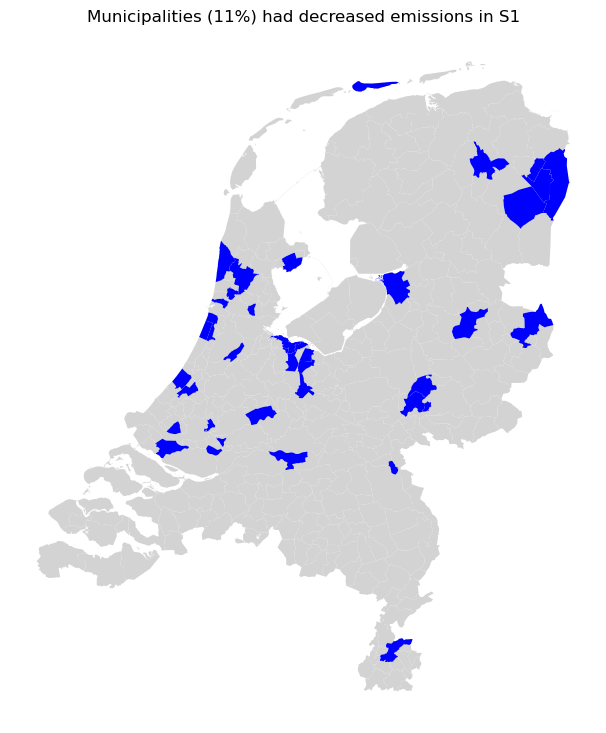

In [25]:
gdf_positive = gdf[gdf.diff_total >= 0]
gdf_negative = gdf[gdf.diff_total < 0]

fig, ax = plt.subplots(figsize=(15, 9))
gdf_positive.plot(color='lightgrey', ax=ax)
gdf_negative.plot(color='blue', ax=ax)
ax.set_axis_off()
ax.set_title(f'Municipalities ({round(len(gdf_negative)/len(gdf) * 100)}%) had decreased emissions in S1')
plt.show()

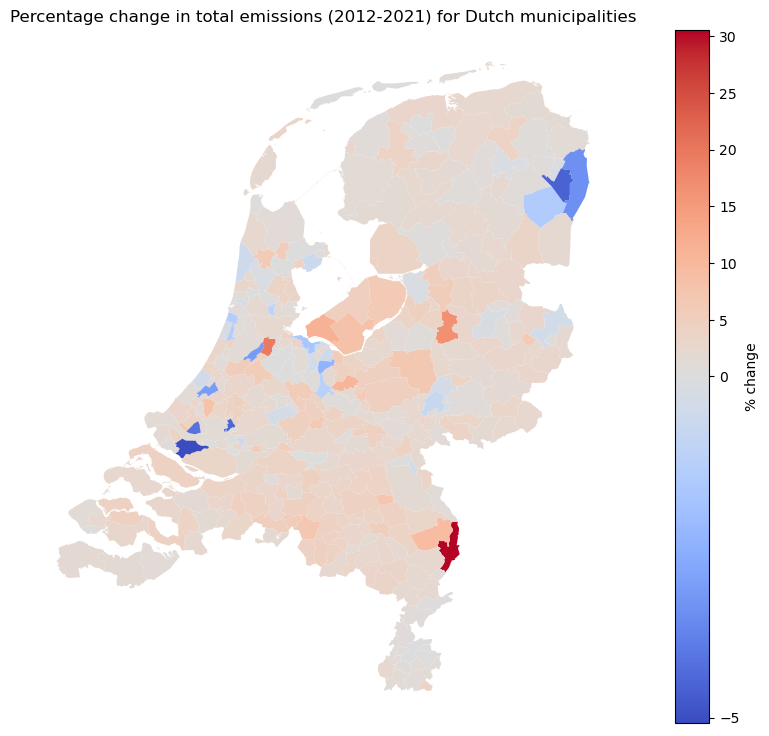

In [24]:
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm

fig, ax = plt.subplots(1, 1, figsize=(15, 9))
# Use TwoSlopeNorm to center the color map at 0
norm = TwoSlopeNorm(vmin=gdf['diff_total_pct'].min(), vcenter=0, vmax=gdf['diff_total_pct'].max())
gdf.plot(column='diff_total_pct', cmap='coolwarm', legend=True, ax=ax, norm=norm, 
         legend_kwds={'label': "% change"})
ax.set_axis_off()
ax.set_title('Percentage change in total emissions (2012-2021) for Dutch municipalities')
plt.show()


In [25]:
fig = px.scatter(gdf, x='diff_operational_pct', y='diff_embodied_pct', 
                 hover_name='municipality', 
                 title="Percentage change in operational vs embodied emissions for Dutch municipalities")
fig.update_layout(width=800, height=700)
fig.show()

In [9]:
municipality = 'Vlaardingen'
query = f''' 
WITH emissions_with_municipality AS (
    SELECT b.municipality, a.wk_code, a.year, a.n_units, 
		a.embodied_kg_s0, a.embodied_kg_s1, 
		a.operational_kg_s0, a.operational_kg_s1
	FROM emissions_all_wijk_s1 a 
	LEFT JOIN key_wijk2012_to_municipality2022 b 
	ON a.wk_code = b.wk_code
), 
emissions_municipality AS (
    SELECT municipality, year, 
        SUM(operational_kg_s0) AS operational_kg_s0, 
        SUM(operational_kg_s1) AS operational_kg_s1, 
        SUM(operational_kg_s1) - SUM(operational_kg_s0) AS diff_operational,
        SUM(embodied_kg_s0) AS embodied_kg_s0, 
        SUM(embodied_kg_s1) AS embodied_kg_s1, 
        SUM(embodied_kg_s1) - SUM(embodied_kg_s0) AS diff_embodied,
        SUM(operational_kg_s0 + embodied_kg_s0) AS total_kg_s0,
        SUM(operational_kg_s1 + embodied_kg_s1) AS total_kg_s1, 
        SUM(operational_kg_s1 + embodied_kg_s1) - SUM(operational_kg_s0 + embodied_kg_s0) AS diff_total
    FROM emissions_with_municipality
    GROUP BY municipality, year
)

SELECT * FROM emissions_municipality 
WHERE municipality = '{municipality}' ORDER BY year
''' 
df = pd.read_sql_query(query, engine)
total_kg_s0 = df.total_kg_s0.sum()
total_kg_s1 = df.total_kg_s1.sum()

df_bar = pd.DataFrame({'scenario': ['s0 - actual emissions', 's1 - energy efficiency'], 'total_kg': [total_kg_s0, total_kg_s1]})
fig = px.bar(df_bar, x='scenario', y='total_kg', title=f'Emissions difference for Vlaardingen: {round((total_kg_s1 - total_kg_s0)/1000000)} million kgCO2eq, {round((total_kg_s1 - total_kg_s0) / total_kg_s0 * 100)}%', 
             labels={'value':'kg CO2e', 'variable':'Scenario'})
fig.update_layout(width=600)
fig.show()

In [ ]:
municipality = 'Vlaardingen'
query = f''' 
WITH emissions_with_municipality AS (
    SELECT b.municipality, a.wk_code, a.year, a.n_units, 
		a.embodied_kg_s0, a.embodied_kg_s1, 
		a.operational_kg_s0, a.operational_kg_s1
	FROM emissions_all_wijk_s1 a 
	LEFT JOIN key_wijk2012_to_municipality2022 b 
	ON a.wk_code = b.wk_code
), 
emissions_municipality AS (
    SELECT municipality, year, 
        SUM(operational_kg_s0) AS operational_kg_s0, 
        SUM(operational_kg_s1) AS operational_kg_s1, 
        SUM(operational_kg_s1) - SUM(operational_kg_s0) AS diff_operational,
        SUM(embodied_kg_s0) AS embodied_kg_s0, 
        SUM(embodied_kg_s1) AS embodied_kg_s1, 
        SUM(embodied_kg_s1) - SUM(embodied_kg_s0) AS diff_embodied,
        SUM(operational_kg_s0 + embodied_kg_s0) AS total_kg_s0,
        SUM(operational_kg_s1 + embodied_kg_s1) AS total_kg_s1, 
        SUM(operational_kg_s1 + embodied_kg_s1) - SUM(operational_kg_s0 + embodied_kg_s0) AS diff_total
    FROM emissions_with_municipality
    GROUP BY municipality, year
)

SELECT * FROM emissions_municipality 
WHERE municipality = '{municipality}' ORDER BY year
''' 
df = pd.read_sql_query(query, engine)

fig = px.bar(df, x='year', y=['total_kg_s0', 'total_kg_s1'], 
             title=f'Housing emissions for {municipality} (2012-2021)',
                labels={'value':'kg CO2e', 'variable':'Emission Type', 'year':'Year'}, barmode='group')
fig.update_layout(width=800)
fig.show()

fig = px.bar(df, x='year', y=['embodied_kg_s0', 'embodied_kg_s1'], 
             title=f'Embodied emissions for {municipality} (2012-2021)',
                labels={'value':'kg CO2e', 'variable':'Emission Type', 'year':'Year'}, barmode='group')
fig.update_layout(width=800)
fig.show()

fig = px.bar(df, x='year', y=['operational_kg_s0', 'operational_kg_s1'], 
             title=f'Operational emissions for {municipality} (2012-2021)',
                labels={'value':'kg CO2e', 'variable':'Emission Type', 'year':'Year'}, barmode='group')
fig.update_layout(width=800)
fig.show()

### Comparing different neighborhoods on a matrix
- Which neighborhoods benefit the most from scenario 1? The least? 

# Scenario 2 - circular economy

In [47]:
query = ''' 
WITH emissions_s0_s1 AS (
	SELECT year, municipality, wk_code, wk_geom, 
		operational_kg_s0, operational_kg_s1, embodied_kg_s0, embodied_kg_s1
	FROM emissions_all_wijk_s1
), 
emissions_all AS (
	SELECT b.*, a.embodied_kg_s2, a.operational_kg_s2
	FROM emissions_all_wijk_s2 a 
	LEFT JOIN emissions_s0_s1 b 
	ON a.year = b.year
		AND a.municipality = b.municipality
		AND a.wk_code = b.wk_code
)

SELECT year, 
	SUM(operational_kg_s0) AS operational_kg_s0, SUM(operational_kg_s1) AS operational_kg_s1, 
	SUM(operational_kg_s2) AS operational_kg_s2, SUM(embodied_kg_s0) AS embodied_kg_s0, 
	SUM(embodied_kg_s1) AS embodied_kg_s1, SUM(embodied_kg_s2) AS embodied_kg_s2, 

	SUM(operational_kg_s0) + SUM(embodied_kg_s0) AS total_kg_s0, 
	SUM(operational_kg_s1) + SUM(embodied_kg_s1) AS total_kg_s1, 
	SUM(operational_kg_s2) + SUM(embodied_kg_s2) AS total_kg_s2
	
FROM emissions_all
WHERE year IS NOT NULL
GROUP BY year 
'''

df = pd.read_sql_query(query, engine)

fig = px.bar(df, x='year', y=['total_kg_s0', 'total_kg_s2'], 
             title=f'Housing emissions for the Netherlands (2012-2021)',
                labels={'value':'kg CO2e', 'variable':'Emission Type', 'year':'Year'}, barmode='group')
fig.update_layout(width=800)
fig.show()

fig = px.bar(df, x='year', y=['embodied_kg_s0', 'embodied_kg_s2'], 
             title=f'Embodied emissions for the Netherlands (2012-2021)',
                labels={'value':'kg CO2e', 'variable':'Emission Type', 'year':'Year'}, barmode='group')
fig.update_layout(width=800)
fig.show()

fig = px.bar(df, x='year', y=['operational_kg_s0', 'operational_kg_s2'], 
             title=f'Operational emissions for the Netherlands (2012-2021)',
                labels={'value':'kg CO2e', 'variable':'Emission Type', 'year':'Year'}, barmode='group')
fig.update_layout(width=800)
fig.show()

In [49]:
total_kg_s0 = df.total_kg_s0.sum()
total_kg_s1 = df.total_kg_s1.sum()
total_kg_s2 = df.total_kg_s2.sum()

df_bar = pd.DataFrame({'scenario': ['s0 - actual emissions', 's1 - energy efficiency', 's2 - material'], 'total_kg': [total_kg_s0, total_kg_s1, total_kg_s2]})

fig = px.bar(df_bar, x='scenario', y='total_kg', title=f'Total emissions (kg) per scenario (difference: {round((total_kg_s2 - total_kg_s0)/total_kg_s0 * 100)}%)', 
             labels={'value':'kg CO2e', 'variable':'Scenario'})
fig.update_layout(width=800)
fig.show()

In [63]:
query = ''' 
WITH emissions AS (
	SELECT a.*, b.operational_kg_s0, b.embodied_kg_s0 
	FROM emissions_all_wijk_s2 a 
	LEFT JOIN emissions_all_wijk_s1 b 
	ON a.wk_code = b.wk_code
		AND a.year = b.year 
), 

emissions_municipality AS (
    SELECT municipality,  
        SUM(operational_kg_s0) AS operational_kg_s0, 
        SUM(operational_kg_s2) AS operational_kg_s2, 
        SUM(operational_kg_s2) - SUM(operational_kg_s0) AS diff_operational,
		CASE
			WHEN SUM(operational_kg_s0) = 0 THEN 0 
			ELSE (SUM(operational_kg_s2) - SUM(operational_kg_s0)) / SUM(operational_kg_s0) * 100
        END AS diff_operational_pct,
	
        SUM(embodied_kg_s0) AS embodied_kg_s0, 
        SUM(embodied_kg_s2) AS embodied_kg_s2, 
        SUM(embodied_kg_s2) - SUM(embodied_kg_s0) AS diff_embodied,
		CASE 
			WHEN SUM(embodied_kg_s0) = 0 THEN 0
			ELSE (SUM(embodied_kg_s2) - SUM(embodied_kg_s0)) / SUM(embodied_kg_s0) * 100 
		END AS diff_embodied_pct,
        
		SUM(operational_kg_s0 + embodied_kg_s0) AS total_kg_s0,
        SUM(operational_kg_s2 + embodied_kg_s2) AS total_kg_s2, 
        SUM(operational_kg_s2 + embodied_kg_s2) - SUM(operational_kg_s0 + embodied_kg_s0) AS diff_total, 
		CASE 
			WHEN SUM(operational_kg_s0 + embodied_kg_s0) = 0 THEN 0 
			ELSE (SUM(operational_kg_s2 + embodied_kg_s2) - SUM(operational_kg_s0 + embodied_kg_s0)) / SUM(operational_kg_s0 + embodied_kg_s0) * 100 
		END AS diff_total_pct
    
	FROM emissions
    GROUP BY municipality
), 
municipalities AS (
    SELECT "GM_NAAM", geometry FROM nl_gemeenten WHERE "H2O" = 'NEE'
)

SELECT a.*, b.geometry
FROM emissions_municipality a
LEFT JOIN municipalities b
ON a.municipality = b."GM_NAAM"
ORDER BY a.diff_total DESC
'''

gdf = gpd.read_postgis(query, engine, geom_col='geometry')

In [66]:
# Assuming gdf is already defined and contains the relevant columns
df = gdf.copy()

# Reshape the DataFrame to long format
df_long = df.melt(id_vars=['municipality'], 
                  value_vars=['diff_total_pct', 'diff_operational_pct', 'diff_embodied_pct'],
                  var_name='Type', 
                  value_name='Percentage')

# Plot the histogram
fig = px.histogram(df_long, x='Percentage', color='Type', 
                   title="Percentage changes for operational, embodied, and total emissions",
                   labels={'Percentage': 'Emissions change (kgCO2eq)', 'Type': 'Category'},
                   nbins=100, marginal='box')  # Adjust nbins as needed
fig.update_layout(width=800)
fig.show()

In [65]:
# Assuming gdf is already defined and contains the relevant columns
df = gdf.copy()

# Reshape the DataFrame to long format
df_long = df.melt(id_vars=['wk_code'], 
                  value_vars=['diff_total_pct', 'diff_operational_pct', 'diff_embodied_pct'],
                  var_name='Type', 
                  value_name='Percentage')

# Plot the histogram
fig = px.histogram(df_long, x='Percentage', color='Type', 
                   title="Percentage changes for operational, embodied, and total emissions",
                   labels={'Percentage': 'Emissions change (kgCO2eq)', 'Type': 'Category'},
                   nbins=100, marginal='box')  # Adjust nbins as needed
fig.update_layout(width=800)
fig.show()

KeyError: "The following id_vars or value_vars are not present in the DataFrame: ['wk_code']"